# Animal Crossing vs Doom - Suggested solution

**Author**: Thien Tran

**Last update**: 21 August 2021

This is the Suggested solution for the MLDA Academics recruitment's Optional task. See the original task [here](https://github.com/gau-nernst/mlda-acad-recruitment).

This notebook is designed to run on Google Colab.

Change runtime type to GPU if you haven't done so.

View GPU info with `nvidia-smi`. If you are lucky, you will get Tesla T4 from Google Colab. This is the best GPU available here.

In [3]:
!nvidia-smi

Thu Oct  7 11:56:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download the dataset

Use Kaggle API to download the dataset. See [here](https://www.kaggle.com/docs/api) for more information

- Generate and download Kaggle API key from your Kaggle account
- Upload the key to Colab
- Move it to the appropriate folder

In [4]:
!mkdir ../root/.kaggle/
!mv "./kaggle.json" "../root/.kaggle/"

In [5]:
!kaggle datasets download -d andrewmvd/doom-crossing

 98% 979M/997M [00:30<00:00, 36.0MB/s]
100% 997M/997M [00:30<00:00, 34.4MB/s]


In [6]:
!unzip doom-crossing.zip -d dataset > /dev/null

4 main steps

1. Prepare dataset
2. Choosing a suitable model
3. Train the model
4. Evaluate and finetune

## Visualize the dataset

Folder structure

```bash
|-- animal_crossing
|   |-- img1.jpg
|   |-- ...
|-- doom
|   |-- img2.jpg
|   |-- ...
```

`torch.utils.data.Dataset`

In [8]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder("dataset")
class_to_idx = dataset.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}

# text label to integer labels
class_to_idx

{'animal_crossing': 0, 'doom': 1}

1


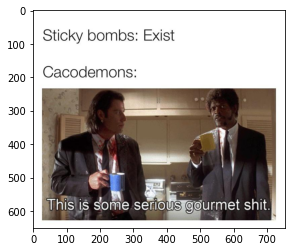

In [19]:
import matplotlib.pyplot as plt

img, label = dataset[1400] # 2nd item
print(label)
plt.imshow(img)

RGB image
- array of pixels
- at each location, you have 3 values representing (RGB)

RGB is not the only **color space** that we can use. Lab

Instead of RGB, you can store: Intensity, Saturation, Hue

In [21]:
import numpy as np

np.array(img).shape     # height, width, channels

(651, 754, 3)

In [18]:
len(dataset)

1597

In [ ]:
import random
import matplotlib.pyplot as plt

indices = random.sample(range(len(dataset)), 10)
plt.figure(figsize=(20,10))

for i, idx in enumerate(indices):
    img, label = dataset[idx]
    
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(idx_to_class[label])

## Train - Validation split

Do 80-20 split for train and validation

**Note**: Some submissions do train-validation-test split. This is a good practice to have 3 separate splits. However, for a simple task like this, it is fine to only do train-validation split.

Purpose of each split:

- **Train**: used for training. Your model will learn from this set
- **Validation**: used for evaluation during training. This includes testing for overfitting, hyperparameter tuning. Your model will **not learn** from this set, but you will use this set **many times** during training.
- **Test**: used for final evaluation. This will only be used **once**, after you have trained and tuned your models (using the train and validation set). In research, evaluation metrics on this set are used to results reporting.

There are special requirements to prepare a good train-validation or train-validation-test split. You will learn more about this later.

Another reason it's a good idea to have a separate validation and test splits is that you can **overfit the validation set**. If you do heavy tuning on the validation set, you have implicitly "overfitted" the validation set. Thus running evaluation on another set (test set) will prevent this problem.

There are other approaches to prevent this problem also, such as **cross-validation**.

In [23]:
from torch.utils.data import random_split

val_size = len(dataset) // 5
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, (train_size, val_size))

print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))

Train size: 1278
Validation size: 319


## Define Dataset

I will be using PyTorch and PyTorch Lightning to do this task. This is just a personal preference

You can read more about them here

- PyTorch: https://pytorch.org/
- PyTorch Lightning: https://www.pytorchlightning.ai/

To understand more about PyTorch Dataset, read [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

### Define data transformations

- Train set: resize + augmentation
- Validation / test set: resize

There are many benefits of data augmentation:

- Neural networks are notorious for overfitting. Data augmentation introduces more **variations** in the training set as a form of **regularization**
- For a small dataset like this, augmentation is equivalent to **generating more samples** for training
- Augmentation can be used to **simulate** certain behaviors or data characteristics that are not present or lacking in the training set

Data augmentation is also an interesting topic for research. There are many modern advanced techniques, such as CutMix, Random Erasing, Copy Paste. Again, there are special considerations for augmentation also. You will learn more about this.

In [ ]:
import torchvision.transforms as T
from copy import deepcopy

# define transformations for training set
train_transforms = T.Compose([
    # transformations that don't change the identity/label of the image → reduce overfitting
    T.RandomResizedCrop((224,224)), 
    T.RandomHorizontalFlip(), 
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.ToTensor()
])

# define transformations for validation set
val_transforms = T.Compose([
    # no data augmentation for the validation
    T.Resize((224,224)),
    T.ToTensor()
])

val_ds = deepcopy(val_ds)

train_ds.dataset.transform = train_transforms
val_ds.dataset.transform = val_transforms

# visualize the images after transformations
plt.figure(figsize=(20,10))
for i in range(5):
    img, label = train_ds[i]
    
    plt.subplot(2,5,i+1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.title(f"Train: {idx_to_class[label]}")

    img, label = val_ds[i]
    
    plt.subplot(2,5,i+6)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.title(f"Validation: {idx_to_class[label]}")

**Note**: for transfer learning, it is important that your data pre-processing (transformation and normalization) is **the same** as what the model was previously trained with. You have to look at where you get your pre-trained model to find out the config they used. 

I actually ignore normalization with ImageNet statistics, as recommended by `torchvision`. For this simple example, it won't make a significant difference.

## Define the model

I will use PyTorch Lightning to define my model. It is a wrapper around PyTorch to help you build and experiment with machine learning models faster.

In [26]:
!pip install -U pytorch-lightning -q

     |████████████████████████████████| 925 kB 4.3 MB/s 
     |████████████████████████████████| 125 kB 49.5 MB/s 
     |████████████████████████████████| 636 kB 41.2 MB/s 
     |████████████████████████████████| 282 kB 54.6 MB/s 
     |████████████████████████████████| 829 kB 36.6 MB/s 
     |████████████████████████████████| 1.3 MB 37.6 MB/s 
     |████████████████████████████████| 160 kB 52.1 MB/s 
     |████████████████████████████████| 271 kB 50.6 MB/s 


Pre-trained models are trained on ImageNet dataset. 1000 classes

Classification: last layer is always a Linear layer (Dense layer). Number of outputs = number classes

In [27]:
import pytorch_lightning as pl                  # import pytorch lightning
from torchvision.models import resnet18         # import ResNet18
import torch
from torch import nn
import torch.nn.functional as F

# Pytorch lightning → creates a system
# 1. model definition: what are the components, how inference is done (forward pass)...
# 2. training recipe: loss functions, what optimizers, learning rate...

class ImageClassifier(pl.LightningModule):
    # MODEL DEFINITION
    def __init__(self, num_classes, loss_fn, learning_rate=1e-2):
        # define the components of the model here
        super().__init__()
        self.backbone = resnet18(pretrained=True)                       # create a ResNet18 model with pre-trained weights
        fc_in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(fc_in_features, num_classes)       # replace the last Linear/Dense layer with our number of classes

        self.loss_fn = loss_fn
        self.learning_rate = learning_rate

    # this is used for inference
    def forward(self, img):
        logits = self.backbone(img)         # pre-trained
        return logits                       # number before softmax

    # TRAINING RECIPE
    # model is trained here
    # training → calculate loss
    def training_step(self, batch, batch_idx):
        img, label = batch
        logits = self.backbone(img)                 # forward pass through the model
        loss = self.loss_fn(logits, label)          # apply cross entropy loss

        self.log("train/loss", loss)
        return loss

    # model is evaluated with validation set here
    # relevant evaluation metrics
    def validation_step(self, batch, batch_idx):
        img, label = batch
        logits = self.backbone(img)
        loss = self.loss_fn(logits, label)

        preds = torch.argmax(logits, dim=-1)            # prediction is the index with highest output
        acc = (label == preds).sum() / label.numel()    # calculate accuracy

        # precision, recall, F1 score. binary classification
        # multi-class classification
        
        self.log("val/loss", loss)
        self.log("val/acc", acc)

    # define the optimizer and learning rate scheduler
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.learning_rate, steps_per_epoch=len(self.train_dataloader()), epochs=self.trainer.max_epochs)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

model = ImageClassifier(2, nn.CrossEntropyLoss())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In the Lightning Module above, I have defined 5 methods:

- `__init__()`: this is the class constructor. We will define our model here, which is a pre-trained ResNet18 from torchvision
- `forward()`: this is the forward pass of the model to get output probabilities
- `training_step()`: calculate the loss here during training
- `validation_step()`: same as training step. In addition, we will also calculate the accuracy here
- `configure_optimizers()`: define the optimizer and learning rate scheduler here

See Lightning documentation [here](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html) for more information.

### General considerations

**Model choice** You can choose any CNN models from this task. For such a small dataset, a small model, such as ResNet18, should suffice. MobileNetv2 is also a good choice.

**Number of outputs** Since we only have 2 classes, we can either treat this as a **binary classification**, which only needs 1 output neuron, or **multi-class classification**, which needs 2 output neurons. Either approach should be fine to classify 2 classes, but later you will see having 2 output neurons is more suitable.

**Loss function** If you use 1 output neuron, your loss function should be **binary cross-entropy loss**. If you use 2 output neurons, your loss should be **cross-entropy loss**. *Question to think about: Can you use mean squared error loss, or other types of regression loss?*

**Optimizer** Popular optimizers are SGD, Adam, and RMSprop. Any optimizer should work fine here. From my personal experience, SGD usually works better for transfer learning.

### Transfer learning considerations

When we create a new classification head, that layer is initialized randomly, but the rest of the model has already been trained. Thus we need to **warm up** the newly created layer, so that we won't destroy the learned weights from the rest of the model.

There are several approaches to do this. One way is to **train only the classification head**, while freezing the rest of the model, for a few epochs, then train the whole model. This is a common approach I saw in the submissions.

Another way is to use a learning rate scheduler to **slowly increase learning rate** from a very small value to a desired value. This ensures the model learns slowly at first, to warm up the new layers, before taking more aggressive steps to update the weights. This is the method I use when I specify learning rate scheduler `OneCycleLR` above.

## Training

### Create a trainer

We will specify training configuration here.

Read Trainer documentation [here](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) for more information.

In [28]:
from pytorch_lightning.callbacks import LearningRateMonitor

trainer = pl.Trainer(
    gpus=1,                             # use 1 GPU
    precision=16,                       # use mixed-precision training
    max_epochs=10,                      # train for 10 epochs
    log_every_n_steps=5,
    callbacks=[LearningRateMonitor()]
)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### Start training

We create dataloaders for training and validation set

- **Batch size**: number of images per batch of image. This should be set to the largest power of 2 that we can fit 1 batch of images to the GPU VRAM
- **Shuffle**: shuffle train set but not the validation set. This serves as a form of regularization also
- **Num workers**: number of CPU threads used for loading data. Since Colab only gives us 2 CPU threads, set this to 2
- **Pin memory**: speed up data transfer from CPU to GPU

**Note**: seems like data loading process in Colab is bottlenecked by CPU. Thus I don't set batch size to a very big number.

Google Colab only 2 CPUs → bottleneck. Even with large batch size, CPU can't keep up with the GPU.

In [30]:
from torch.utils.data import DataLoader

# batch the data
# batch size: largest number that your GPU memory can contain
train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

model = ImageClassifier(2, nn.CrossEntropyLoss())

trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | backbone | ResNet           | 11.2 M
1 | loss_fn  | CrossEntropyLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Building block of MLP: 

1. matrix multiplication
2. non-linear activation (relu)
3. batch norm

In [43]:
model.backbone.conv1        # convolution layer
weights = model.backbone.conv1.weight.clone().detach()
weights.shape

torch.Size([64, 3, 7, 7])

7x7 kernel, with input channels = 3, output channels = 64

There are 64 filters/kernels. Each will match with a specific pattern

In [57]:
model.backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

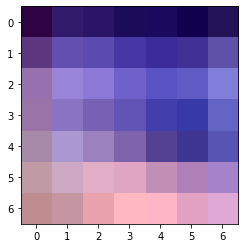

In [47]:
# 1 filter / kernel
filter = weights[2].numpy().transpose(1,2,0)
filter = (filter - filter.min()) / (filter.max() - filter.min())
plt.imshow(filter)

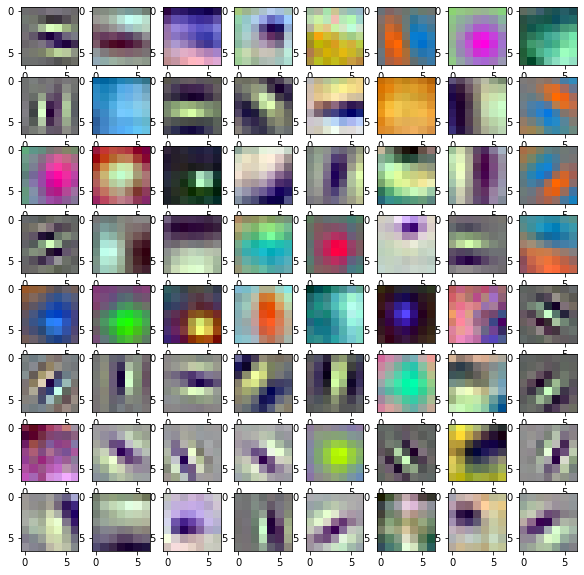

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(weights.shape[0]):
    filter = weights[i].numpy().transpose(1,2,0)
    filter = (filter - filter.min()) / (filter.max() - filter.min())

    plt.subplot(8,8,i+1)
    plt.imshow(filter)

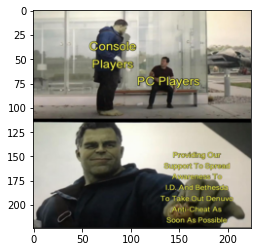

In [53]:
img, label = val_ds[0]
plt.imshow(img.numpy().transpose(1,2,0))

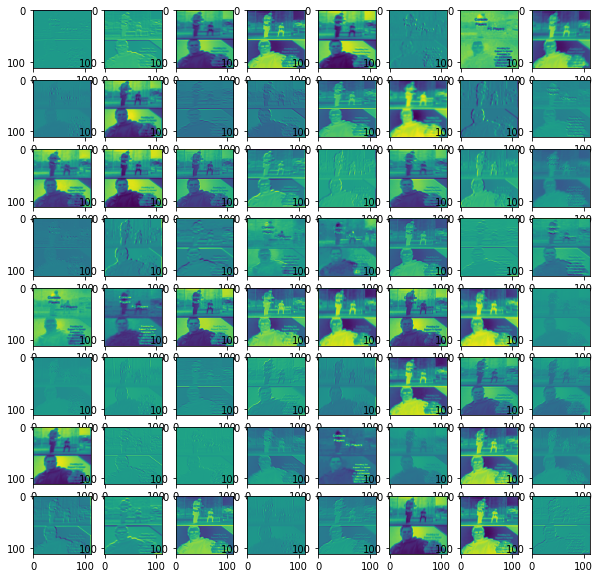

In [56]:
with torch.no_grad():
    out = model.backbone.conv1(img.unsqueeze(0))

plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(out[0,i].numpy())